# General Info

dataset: LFW-People (https://www.kaggle.com/atulanandjha/lfwpeople/data)

VGGFace2
(https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/)

In [2]:
import os
import pandas as pd
import numpy as np
import cv2

In [3]:
_, dirs,_ = next(os.walk("./dataset"))

In [4]:
folders = pd.DataFrame(dirs)

In [5]:
folders.columns = ["name"]

In [6]:
folders.head()

,name
0,Martin_Boryczewski
1,Bobby_Jackson
2,Sven_Ottke
3,Alan_Zemaitis
4,Ashraf_Alasmar


## Picture Urls

In [7]:
folders["file"] = folders["name"].apply(lambda x: os.listdir("./dataset/"+x))

In [8]:
folders.count()

name    5749
file    5749
dtype: int64

In [9]:
pictures = pd.DataFrame(folders.file.tolist(), index=folders.name).stack().reset_index(level=1, drop=True).reset_index(name='file')[['file','name']]

In [10]:
pictures.count()

file    13233
name    13233
dtype: int64

## Detecting Face

In [11]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt
from IPython.display import Image

Using TensorFlow backend.


In [12]:
detector = MTCNN()

In [13]:
testfile = 'dataset/Frank_Dunham_Jr/Frank_Dunham_Jr_0002.jpg'

In [14]:
def extract_face(filename, required_size=(224, 224)):

    pixels = cv2.imread(filename)
    pixels_rgb = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
    
    results = detector.detect_faces(pixels_rgb)
    
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels_rgb[y1:y2, x1:x2]
    
    if face.shape[0]>0 and face.shape[1]>0:
        face_rsz = cv2.resize(face, required_size)
    else:
        face_rsz = 'no_face'
    return face_rsz

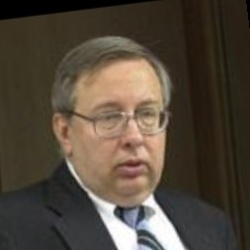

In [15]:
Image(testfile)

## Feature Extraction

In [68]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [69]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [70]:
def get_embeddings(filename):
    face = extract_face(filename)
    if face == 'no_face':
        return '-'
    sample = np.asarray(face, 'float32')
    sample = np.expand_dims(sample, axis=0)
    sample = preprocess_input(sample, version=2)
    
    embedding = model.predict(sample)
    
    return embedding[0]

In [71]:
emb = get_embeddings(testfile)

/home/paulorcmendes/.local/share/virtualenvs/face_clustering-_i1mKbvK/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
complete_urls = 'dataset/'+pictures['name']+'/'+pictures['file']

In [73]:
embeddings = complete_urls.apply(lambda x: get_embeddings(x))

/home/paulorcmendes/.local/share/virtualenvs/face_clustering-_i1mKbvK/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
embeddings.head()

0    [0.0, 1.6660573, 0.0, 0.0, 0.0, 0.0, 2.9247637...
1    [0.0, 0.47519812, 2.0513406, 5.2823005, 0.9486...
2    [0.0, 0.038900744, 0.0, 4.4667716, 0.42058718,...
3    [0.0, 3.5332255, 8.2842455, 0.0, 0.12660573, 1...
4    [0.0, 0.0, 0.02146301, 0.0, 0.017755207, 0.0, ...
dtype: object

In [81]:
pictures["complete_url"] = complete_urls

In [75]:
pictures['embeddings'] = embeddings

In [82]:
pictures.head()

,file,name,embeddings,complete_url
0,Martin_Boryczewski_0001.jpg,Martin_Boryczewski,"[0.0, 1.6660573, 0.0, 0.0, 0.0, 0.0, 2.9247637...",dataset/Martin_Boryczewski/Martin_Boryczewski_...
1,Bobby_Jackson_0001.jpg,Bobby_Jackson,"[0.0, 0.47519812, 2.0513406, 5.2823005, 0.9486...",dataset/Bobby_Jackson/Bobby_Jackson_0001.jpg
2,Sven_Ottke_0001.jpg,Sven_Ottke,"[0.0, 0.038900744, 0.0, 4.4667716, 0.42058718,...",dataset/Sven_Ottke/Sven_Ottke_0001.jpg
3,Alan_Zemaitis_0001.jpg,Alan_Zemaitis,"[0.0, 3.5332255, 8.2842455, 0.0, 0.12660573, 1...",dataset/Alan_Zemaitis/Alan_Zemaitis_0001.jpg
4,Ashraf_Alasmar_0001.jpg,Ashraf_Alasmar,"[0.0, 0.0, 0.02146301, 0.0, 0.017755207, 0.0, ...",dataset/Ashraf_Alasmar/Ashraf_Alasmar_0001.jpg


Removendo imagens em que não foi possível extrair os embeddings

In [21]:
invalid = pictures.loc[pictures["embeddings"] == '-'].index

In [26]:
print("Numero de imagens invalidas: "+str(len(invalid)))

Numero de imagens invalidas: 38


In [28]:
pictures = pictures.drop(invalid)

## Saving DataFrame

In [29]:
pictures.to_pickle('faces_embeddings.pkl')